# CS5489 - Tutorial 4
## Face Detection in Images

In this tutorial you will train a classifier to detect whether there is a face in a small image patch.  This type of face detector is used in your phone and camera whenever you take a picture!

First we need to initialize Python.  Run the below cell.

In [4]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)
from scipy import ndimage
from scipy import signal
from scipy import stats
import skimage.color
import skimage.exposure
import skimage.io
import skimage.util
import xgboost as xgb

## Loading Data and Pre-processing
Next we need to load the images.  Download `faces.zip`, and put it in the same direcotry as this ipynb file.  **Do not unzip the file.** Then run the following cell to load the images.

In [5]:
imgdata = {'train':[], 'test':[]}
classes = {'train':[], 'test':[]}

# the dataset is too big, so subsample the training and test sets...
# reduce training set by a factor of 4
train_subsample = 4  
train_counter = [0, 0]
# maximum number of samples in each class for test set
test_maxsample = 472
test_counter = [0, 0]

# load the zip file
filename = 'faces.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "faces/*/*/*.png"):
        
        # filename is : faces/train/face/fname.png
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (face, nonface)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        # class 1 = face; class 0 = non-face
        myclass = int(fclass == "face")  

        loadme = False
        if fset == 'train':
            if (train_counter[myclass] % train_subsample) == 0:
                loadme = True
            train_counter[myclass] += 1
        elif fset == 'test':
            if test_counter[myclass] < test_maxsample:
                loadme = True
            test_counter[myclass] += 1
            
        if (loadme):
            # open file in memory, and parse as an image
            myfile = zfile.open(name)
            #img = matplotlib.image.imread(myfile)
            img = skimage.io.imread(myfile, as_gray=True) # read as grayscale
            myfile.close()
            
            # append data
            imgdata[fset].append(img)
            classes[fset].append(myclass)

        
zfile.close()
imgsize = img.shape

print(len(imgdata['train']))
print(len(imgdata['test']))
trainclass2start = sum(classes['train'])

1745
944


Each image is a 19x19 array of pixel values.  Run the below code to show an example:

(19, 19)


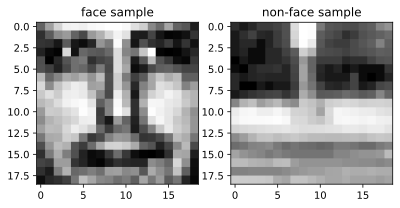

In [6]:
print(img.shape)
plt.subplot(1,2,1)
plt.imshow(imgdata['train'][0], cmap='gray', interpolation='nearest')
plt.title("face sample")
plt.subplot(1,2,2)
plt.imshow(imgdata['train'][trainclass2start], cmap='gray', interpolation='nearest')
plt.title("non-face sample")
plt.show()

Run the below code to show more images!

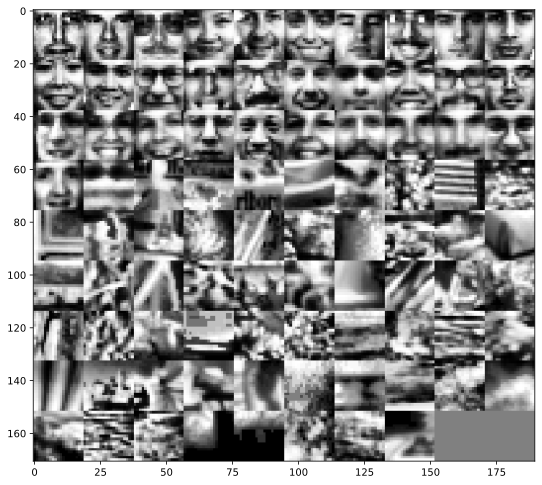

In [7]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(X[i])
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

# show a few images
plt.figure(figsize=(9,9))
plt.imshow(image_montage(imgdata['train'][::20]), cmap='gray', interpolation='nearest')
plt.show()

Each image is a 2d array, but the classifier algorithms work on 1d vectors. Run the following code to convert all the images into 1d vectors by flattening.  The result should be a matrix where each row is a flattened image.

In [8]:
trainX = empty((len(imgdata['train']), prod(imgsize)))
for i,img in enumerate(imgdata['train']):
    trainX[i,:] = ravel(img)
trainY = asarray(classes['train'])  # convert list to numpy array
print(trainX.shape)
print(trainY.shape)

testX = empty((len(imgdata['test']), prod(imgsize)))
for i,img in enumerate(imgdata['test']):
    testX[i,:] = ravel(img)
testY = asarray(classes['test'])  # convert list to numpy array
print(testX.shape)
print(testY.shape)

(1745, 361)
(1745,)
(944, 361)
(944,)


## Detection using  pixel values

Train an AdaBoost and GradientBoosting classifiers to classify an image patch as face or non-face.  Also train a kernel SVM classifier using either RBF or polynomial kernel, and a Random Forest Classifier.  Evaluate all your classifiers on the test set.

First we will normalize the features.

In [9]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))  # make scaling object
trainXn = scaler.fit_transform(trainX)   # use training data to fit scaling parameters
testXn = scaler.transform(testX)        # apply scaling to test data

In [7]:
### INSERT YOUR CODE HERE

####  RBF SVM

In [10]:
# setup the list of parameters to try
paramgrid = {'C': logspace(-2, 3, 10), 'gamma': logspace(-4, 3, 10)}
# setup the cross-validation object
# pass the SVM object w/ rbf kernel, parameter grid, and number of CV folds
svmcv = model_selection.GridSearchCV(svm.SVC(kernel='rbf'), paramgrid, cv=5, n_jobs=-1, verbose=True)
# run cross-validation (train for each split)
svmcv.fit(trainX, trainY)
print("best params:", svmcv.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
best params: {'C': 5.994842503189409, 'gamma': 0.021544346900318846}


#### AdaBoost 

In [11]:
# setup the list of parameters to try
paramgrid = {'learning_rate': logspace(-6, 0, 10), 'n_estimators': array([1, 2, 3, 5, 10, 15, 20, 25, 50, 100, 200, 500, 1000])}
# setup the cross-validation object
adacv = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(random_state=4487), paramgrid, cv=5, n_jobs=-1)
# run cross-validation (train for each split)
adacv.fit(trainX, trainY)
print("best params:", adacv.best_params_)

best params: {'learning_rate': 1.0, 'n_estimators': 1000}


#### GradientBoosting

In [12]:
xclf = xgb.XGBClassifier(objective="binary:logistic", eval_metric='logloss', random_state = 4487, use_label_encoder = False)
paramgrid = {'learning_rate': logspace(-6, 0, 10), 'n_estimators': array([1, 2, 3, 5, 10, 15, 20, 25, 50, 100, 200, 500, 1000])}
# setup the cross-validation object
xgbcv = model_selection.GridSearchCV(xclf, paramgrid, cv=5, n_jobs=-1)
# run cross-validation (train for each split)
xgbcv.fit(trainX, trainY)
print("best params:", xgbcv.best_params_)

C:\Users\yingyinyu3\Anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\yingyinyu3\Anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\yingyinyu3\Anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


best params: {'learning_rate': 0.21544346900318823, 'n_estimators': 200}


#### Random Forest Classifier

In [13]:
# setup the list of parameters to try
paramsampler = {'max_features': stats.uniform(0, 1.0), 'max_depth': stats.randint(1, 5),
'min_samples_split': stats.uniform(0, 0.5), 'min_samples_leaf': stats.uniform(0, 0.5)}
# setup the cross-validation object
rfcv = model_selection.RandomizedSearchCV(ensemble.RandomForestClassifier(n_estimators = 100,random_state=4), param_distributions=paramsampler, random_state = 4487, n_iter=1000, cv=5, verbose = 1, n_jobs=-1)
# run cross-validation (train for each split)
rfcv.fit(trainX, trainY)
print("best params:", rfcv.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
best params: {'max_depth': 3, 'max_features': 0.07416911852708219, 'min_samples_leaf': 0.01968717518041524, 'min_samples_split': 0.0548941379143123}


In [14]:
print("RBF test accuracy=", metrics.accuracy_score(testY, svmcv.predict(testX)))
print("AdaBoost test accuracy=", metrics.accuracy_score(testY, adacv.predict(testX)))
print("GradientBoosting test accuracy=", metrics.accuracy_score(testY, xgbcv.predict(testX)))
print("Random Forest test accuracy=", metrics.accuracy_score(testY, rfcv.predict(testX)))

RBF test accuracy= 0.6610169491525424
AdaBoost test accuracy= 0.6260593220338984
GradientBoosting test accuracy= 0.6641949152542372
Random Forest test accuracy= 0.6504237288135594


_Which classifier was best?_
- **INSERT YOUR ANSWER HERE**

- GradientBoost is the best after cross validation

### Error analysis
The accuracy only tells part of the classifier's performance. We can also look at the different types of errors that the classifier makes:
- _True Positive (TP)_: classifier correctly said face
- _True Negative (TN)_: classifier correctly said non-face
- _False Positive (FP)_: classifier said face, but not a face
- _False Negative (FN)_: classifier said non-face, but was a face

This is summarized in the following table:

<table>
<tr><th colspan=2 rowspan=2><th colspan=2 style="text-align: center">Actual</th></tr>
<tr>  <th>Face</th><th>Non-face</th></tr>
<tr><th rowspan=2>Prediction</th><th>Face</th><td>True Positive (TP)</td><td>False Positive (FP)</td></tr>
<tr>  <th>Non-face</th><td>False Negative (FN)</td><td>True Negative (TN)</td></tr>
</table>

We can then look at the _true positive rate_ and the _false positive rate_.
- _true positive rate (TPR)_: proportion of true faces that were correctly detected
- _false positive rate (FPR)_: proportion of non-faces that were mis-classified as faces.

Use the below code to calculate the TPR and FPR of your classifiers.

In [15]:
# predY is the prediction from the classifier
predY = xgbcv.predict(testX)
Pind = where(predY == 1) # indicies for face predictions
Nind = where(predY == 0) # indicies for non-face predictions
TP = count_nonzero(testY[Pind] == predY[Pind])
FP = count_nonzero(testY[Pind] != predY[Pind])
TN = count_nonzero(testY[Nind] == predY[Nind])
FN = count_nonzero(testY[Nind] != predY[Nind])

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)

print("TP=", TP)
print("FP=", FP)
print("TN=", TN)
print("FN=", FN)
print("TPR=", TPR)
print("FPR=", FPR)

TP= 161
FP= 6
TN= 466
FN= 311
TPR= 0.3411016949152542
FPR= 0.012711864406779662


_How does the classifier make errors?_
- **INSERT YOUR ANSWER HERE**
- 311 of the 472 positive samples were wrongly divided into negative samples, while only 6 of the 477 negative samples were wrongly divided.

### Classifier analysis

For the AdaBoost classifier, we can interpret what it is doing by looking at which features it uses most in the weak learners.  Use the below code to visualize the pixel features used.

Note: if you used GridSearchCV to train the classifier, then you need to use the `best_estimator_` field to access the classifier.

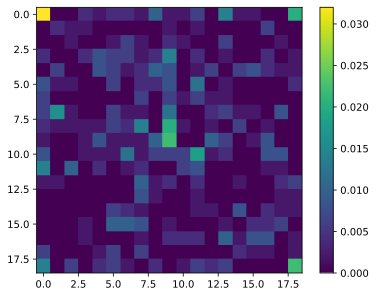

In [16]:
# adaclf is the trained adaboost classifier
adaclf = ensemble.AdaBoostClassifier(random_state=4487, learning_rate=1.0, n_estimators=500)
adaclf = adaclf.fit(trainX, trainY)

fi = adaclf.feature_importances_.reshape(imgsize)
plt.imshow(fi, interpolation='nearest')
plt.colorbar()

Similarly, we can also look at the important features for xgboost.

C:\Users\yingyinyu3\Anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


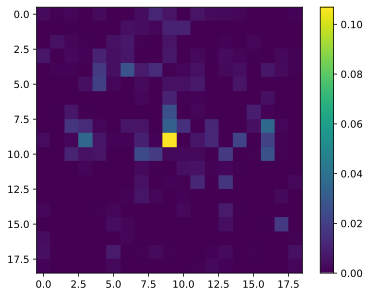

In [17]:
# xgbclf is the trained xgboost classifier
xgbclf = xgb.XGBClassifier(objective="binary:logistic", eval_metric='logloss', random_state=4487, use_label_encoder=False)
xgbclf = xgbclf.fit(trainX, trainY)

fi = xgbclf.feature_importances_.reshape(imgsize)
plt.imshow(fi, interpolation='nearest')
plt.colorbar()

Similarly for Random Forests, we can look at the important features.

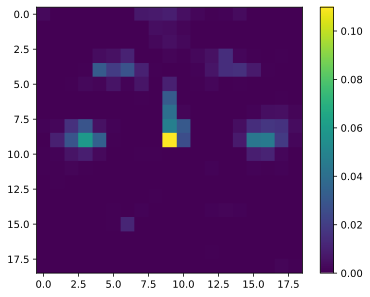

In [18]:
# rfclf is the trained random forest classifier
rfclf = ensemble.RandomForestClassifier(n_estimators=100,n_jobs=8,max_depth=3, max_features=0.07416911852708219, min_samples_leaf= 0.01968717518041524, min_samples_split= 0.0548941379143123)
rfclf = rfclf.fit(trainX, trainY)

fi = rfclf.feature_importances_.reshape(imgsize)
plt.imshow(fi, interpolation='nearest')
plt.colorbar()

Comment on which features (pixels) that AdaBoost and Random Forests are using
- **INSERT YOUR ANSWER HERE**

- AdaBoost uses features that are scattered and almost full face features.
- Random forest is mainly characterized by the middle nose and cheeks.


For kernel SVM, we can look at the support vectors to see what the classifier finds difficult.

num support vectors: 271


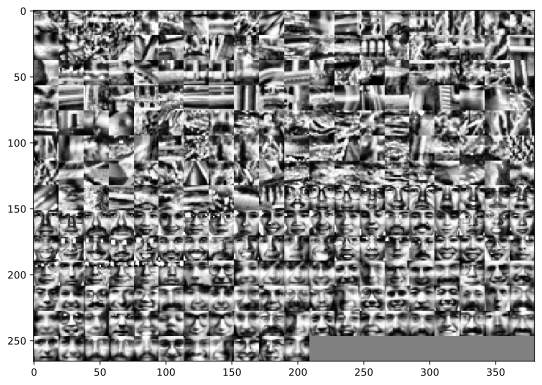

In [20]:
# svmclf is the trained SVM classifier
svmclf = svm.SVC(kernel='rbf', C= 5.994842503189409, gamma=0.021544346900318846)
svmclf = svmclf.fit(trainX, trainY)

print("num support vectors:", len(svmclf.support_vectors_))
si = svmclf.support_  # get indicies of support vectors

# get all the patches for each support vector
simg = [ imgdata['train'][i] for i in si ]

# make montage
outimg = image_montage(simg, maxw=20)

plt.figure(figsize=(9,9))
plt.imshow(outimg, cmap='gray', interpolation='nearest')

Comment on anything you notice about what the SVM finds difficult (i.e., on the decision boundary or within the margin)
- **INSERT YOUR ANSWER HERE**

- 


### Custom kernel SVM

Now we will try to use a custom kernel with the SVM.  We will consider the following RBF-like kernel based on L1 distance (i.e., cityblock or Manhattan distance),

$$ k(\mathbf{x},\mathbf{y}) = \exp \left(-\alpha \sum_{i=1}^d |x_i-y_i|\right)$$

where $x_i,y_i$ are the elements of the vectors $\mathbf{x},\mathbf{y}$, and $\alpha$ is the hyperparameter.  The difference with the RBF kernel is that the new kernel uses the absolute difference rather than the squared difference. Thus, the new kernel does not "drop off" as fast as the RBF kernel using squared distance.

- Implement the new kernel as a custom kernel function. The `scipy.spatial.distance.cdist` function will be helpful.
- Train the SVM with the new kernel.  To select the hyperparameter $\alpha$, you need to run cross-validation "manually" by: 1) trying different values of $\alpha$, and running cross-validation to select $C$; 2) selecting the  $\alpha$ with the highest cross-validation score `best_score_` in `GridSearchCV`.


In [ ]:
### INSERT YOUR CODE HERE


In [21]:
from scipy import spatial

def ManhattenKernel(X1, X2, alpha):
    D = spatial.distance.cdist(X1, X2, metric='cityblock')
    return exp(-alpha*D)

In [22]:
# setup the cross-validation object
alphas = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05]
clf = {}
for i in alphas:
    # make a temporary kernel function with the selected alpha value
    tmpkern = lambda X1,X2,alpha=i: ManhattenKernel(X1,X2,alpha=alpha)
    # create the SVM with custom kernel function
    # setup the list of parameters to try
    paramgrid = {'C': logspace(-2, 3, 10)}
    clf[i] = model_selection.GridSearchCV(svm.SVC(kernel=tmpkern), paramgrid, cv=5, n_jobs=8, verbose=True)
    clf[i].fit(trainX, trainY)
    predY = clf[i].predict(testX)
    print("ACC:", metrics.accuracy_score(testY, predY))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.6790254237288136
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.6546610169491526
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.6048728813559322
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.6175847457627118
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.6546610169491526
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.6673728813559322
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.6641949152542372
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.6483050847457628
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.6271186440677966


Does using the new kernel improve the results?
- **INSERT YOUR ANSWER HERE**

- Through cross validation, it is confirmed that the effect is indeed improved, especially when the alpha is 1e-6.

## Image Feature Extraction
The detection performance is not that good. The problem is that we are using the raw pixel values as features, so it is difficult for the classifier to interpret larger structures of the face that might be important.  To fix the problem, we will extract features from the image using a set of filters.

Run the below code to look at the filter output.  The filters are a sets of black and white boxes that respond to similar structures in the image.  After applying the filters to the image, the filter response map is aggregated over a 4x4 window.  Hence each filter produces a 5x5 feature response.  Since there are 4 filters, then the feature vector is 100 dimensions.

In [23]:
def extract_features(imgs, doplot=False):
    # the filter layout
    lay = [array([-1,1]), array([-1,1,-1]),  
               array([[1],[-1]]), array([[-1],[1],[-1]])]
    sc=8            # size of each filter patch
    poolmode = 'i'  # pooling mode (interpolate)
    cmode = 'same'  # convolution mode
    brick = ones((sc,sc))  # filter patch
    ks = []
    for l in lay:
        tmp = [brick*i for i in l]
        if (l.ndim==1):
            k = hstack(tmp)
        else:
            k = vstack(tmp)
        ks.append(k)

    # get the filter response size
    if (poolmode=='max') or (poolmode=='absmax'):
        tmpimg = maxpool(maxpool(imgs[0]))
    else:
        tmpimg = ndimage.zoom(imgs[0], 0.25)        
    fs = prod(tmpimg.shape)
    
    # get the total feature length
    fst = fs*len(ks)

    # filter the images
    X  = empty((len(imgs), fst))
    for i,img in enumerate(imgs):
        x = empty(fst)

        # for each filter
        for j,th in enumerate(ks):
            # filter the image
            imgk = signal.convolve(img, ks[j], mode=cmode)
            
            # do pooling
            if poolmode == 'maxabs':
                mimg = maxpool(maxpool(abs(imgk)))
            elif poolmode == 'max':
                mimg = maxpool(maxpool(imgk))
            else:
                mimg = ndimage.zoom(imgk, 0.25)
    
            # put responses into feature vector
            x[(j*fs):(j+1)*fs] = ravel(mimg)
               
            if (doplot):             
                plt.subplot(3,len(ks),j+1)
                plt.imshow(ks[j], cmap='gray', interpolation='nearest')
                plt.title("filter " + str(j))
                plt.subplot(3,len(ks),len(ks)+j+1)
                plt.imshow(imgk, cmap='gray', interpolation='nearest')
                plt.title("filtered image")
                plt.subplot(3,len(ks),2*len(ks)+j+1)
                plt.imshow(mimg, cmap='gray', interpolation='nearest')
                plt.title("image features")
        X[i,:] = x
    
    return X

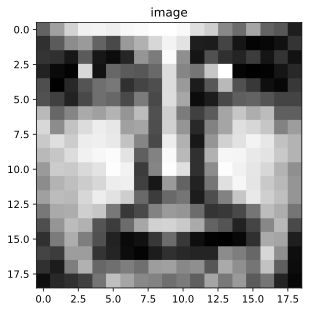

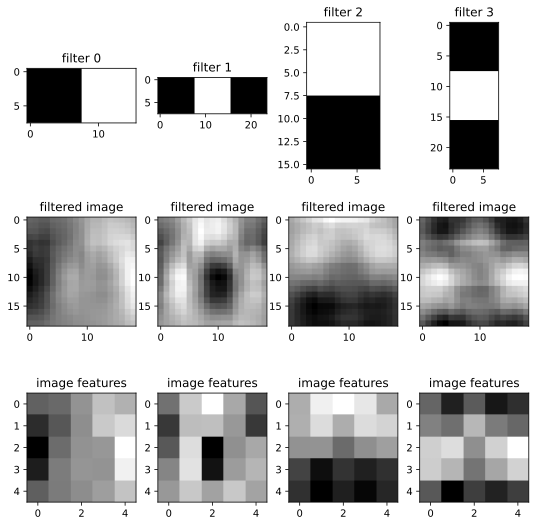

In [24]:
# new features
img = imgdata['train'][0]
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.title("image")
plt.figure(figsize=(9,9))
extract_features([img], doplot=True);

Now lets extract image features on the training and test sets.  It may take a few seconds.

In [25]:
trainXf = extract_features(imgdata['train'])
print(trainXf.shape)
testXf = extract_features(imgdata['test'])
print(testXf.shape)

(1745, 100)
(944, 100)


### Detection using Image Features
Now train AdaBoost and SVM classifiers on the image feature data.  Evaluate on the test set.

In [26]:
# first scale the features
scalerf = preprocessing.MinMaxScaler(feature_range=(-1,1))    # make scaling object
trainXfn = scalerf.fit_transform(trainXf)   # use training data to fit scaling parameters
testXfn = scalerf.transform(testXf)        # apply scaling to test data

In [27]:
### INSERT YOUR CODE HERE

# setup the list of parameters to try
paramgrid = {'learning_rate': logspace(-6, 0, 10), 'n_estimators': array([1, 2, 3, 5, 10, 15, 20, 25, 50, 100, 200, 500, 1000])}
# setup the cross-validation object
adacv = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(random_state=4487), paramgrid, cv=5, n_jobs=8)
# run cross-validation (train for each split)
adacv.fit(trainXfn, trainY)
print("AdaBoost test accuracy=", metrics.accuracy_score(testY, adacv.predict(testXfn)))

AdaBoost test accuracy= 0.7213983050847458


In [29]:
# setup the list of parameters to try
paramgrid = {'C': logspace(-2, 3, 10), 'gamma': logspace(-4, 3, 10)}
# setup the cross-validation object
# pass the SVM object w/ rbf kernel, parameter grid, and number of CV folds
svmcv = model_selection.GridSearchCV(svm.SVC(kernel='rbf'), paramgrid, cv=5, n_jobs=8, verbose=True)
# run cross-validation (train for each split)
svmcv.fit(trainXfn, trainY)
print("SVM test accuracy=", metrics.accuracy_score(testY, svmcv.predict(testXfn)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
SVM test accuracy= 0.7341101694915254


### Error Analysis
Repeat the error analysis for the new classifiers.

In [30]:
### INSERT YOUR CODE HERE
predY = adacv.predict(testXfn)
Pind = where(predY == 1) # indicies for face predictions
Nind = where(predY == 0) # indicies for non-face predictions
TP = count_nonzero(testY[Pind] == predY[Pind])
FP = count_nonzero(testY[Pind] != predY[Pind])
TN = count_nonzero(testY[Nind] == predY[Nind])
FN = count_nonzero(testY[Nind] != predY[Nind])

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)

print("TP=", TP)
print("FP=", FP)
print("TN=", TN)
print("FN=", FN)
print("TPR=", TPR)
print("FPR=", FPR)

TP= 225
FP= 16
TN= 456
FN= 247
TPR= 0.4766949152542373
FPR= 0.03389830508474576


In [31]:
predY = svmcv.predict(testXfn)
Pind = where(predY == 1) # indicies for face predictions
Nind = where(predY == 0) # indicies for non-face predictions
TP = count_nonzero(testY[Pind] == predY[Pind])
FP = count_nonzero(testY[Pind] != predY[Pind])
TN = count_nonzero(testY[Nind] == predY[Nind])
FN = count_nonzero(testY[Nind] != predY[Nind])

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)

print("TP=", TP)
print("FP=", FP)
print("TN=", TN)
print("FN=", FN)
print("TPR=", TPR)
print("FPR=", FPR)

TP= 234
FP= 13
TN= 459
FN= 238
TPR= 0.4957627118644068
FPR= 0.02754237288135593


How has the classifier using image features improved?
- **INSERT YOUR ANSWER HERE**

- The effect of the model has improved a lot, especially in the discrimination of the positive sample, from 34% to nearly 50%. However, the accuracy of negative sample differentiation has decreased.

# Test image
Now lets try your face detector on a real image.  Download the "nasa-small.png" image and put it in the same directory as your ipynb file.  The below code will load the image, crop out image patches and then extract features. (this may take a few minutes)

In [32]:
fname = "nasa-small.png"

(210, 480)


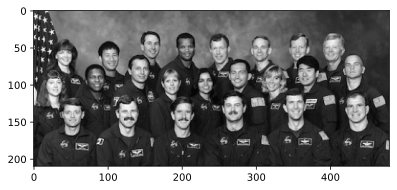

In [33]:
# load image
testimg = skimage.io.imread(fname, as_gray=True)
print(testimg.shape)
plt.imshow(testimg, cmap='gray')

In [34]:
# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3]))
print(patches2.shape )

# histogram equalize patches (improves contrast)
patches3 = empty(patches2.shape)
for i in range(patches2.shape[0]):
    patches3[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])

# extract features
newXf = extract_features(patches3)

(5568, 19, 19)


Now predict using your classifier.  The extracted features are in `newXf`, and scaled features are `newXfn`.

In [35]:
newXfn = scalerf.transform(newXf)        # apply scaling to test data

In [36]:
### INSERT YOUR CODE HERE
#prednewY = adacv.predict(newXfn)
prednewY = svmcv.predict(newXfn)

Now we we will view the results on the image.  Use the below code. `prednewY` is the vector of predictions.

(-0.5, 479.5, 209.5, -0.5)

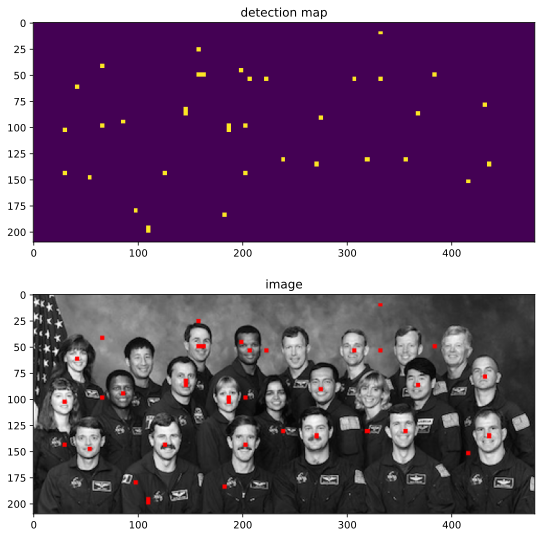

In [37]:
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

_How did your face detector do?_
- **INSERT YOUR ANSWER HERE**
- Most of the facial recognition focuses on the places with obvious features near the nose, and only 5 people's facial recognition is invalid, which is very good overall.

You can try it on your own images.  The faces should all be around 19x19 pixels though. We only used 1/4 of the training data. Try using more data to train it!